In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# NHL Blocked Shots Analysis
## Imports

In [3]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as pl
import statsmodels.formula.api as sm
from scipy import stats

%matplotlib inline

## Load Data

In [4]:
wins = {}
blocks = {}
blockssum = {}
teams = json.load(open('NHL_Teams.json', 'r'))

for i in np.delete(np.arange(2009, 2016), 3):
    # Load data into DataFrames stored in dictionaries.
    wins[str(i)] = pd.read_csv('Wins/Wins{}.txt'.format(str(i)))
    blocks[str(i)] = pd.read_csv(
        'BlockedShots/BlockedShots{}.csv'.format(str(i)))

    # Clean wins data.
    wins[str(i)] = wins[str(i)][[0, 1, 4, 5, 6, 7, 10]].copy()
    wins[str(i)].dropna(how='any', subset=['Rk'], inplace=True)
    wins[str(i)].rename(columns={'Unnamed: 1': 'Team'}, inplace=True)
    wins[str(i)]['Team'] = wins[str(i)].Team.str.strip('*')
    wins[str(i)]['Team'].replace(teams, inplace=True)
    wins[str(i)]['Year'] = i
    wins[str(i)]['UniqueID'] = wins[str(i)]['Team'] + '_' + str(i)
    wins[str(i)]['Playoffs'] = wins[str(i)]['Rk'] < 17

    # Clean blocks data.
    blocks[str(i)]['Year'] = str(i)
    blocks[str(i)]['UniqueID'] = blocks[str(i)]['Team'] + '_' + str(i)
    blocks[str(i)]['Blocks'] = pd.to_numeric(blocks[str(i)]['Blocks'],
                                             errors='coerce')

    # Create blocks summary data.
    blockssum[str(i)] = pd.DataFrame(pd.pivot_table(
            blocks[str(i)], values='Blocks', index='Team', aggfunc=np.sum))
    blockssum[str(i)].reset_index(level=0, inplace=True)
    blockssum[str(i)]['Year'] = str(i)
    blockssum[str(i)]['UniqueID'] = blockssum[str(i)]['Team'] + '_' + str(i)

# Concatenate all years at team level.
TeamBlocks = pd.concat(blockssum.values(), ignore_index=True)
TeamWins = pd.concat(wins.values(), ignore_index=True)

# Merge blocks and wins at team level.
data = TeamWins.merge(TeamBlocks, left_on='UniqueID',
                      right_on='UniqueID', how='inner')
data.drop(data.columns[[1, 7]], axis=1, inplace=True)
data.rename(columns={'Team_y': 'Team', 'Year_y': 'Year'}, inplace=True)
data['RRk'] = 31 - data.Rk

# Do players on good teams block more shots than players on bad teams?

$H_o$: Players on teams who make the playoffs block the same or less shots than players on teams who miss the playoffs.

$H_a$: Players on teams who make the playoffs block more shots than players on teams who miss the playoffs.

In [5]:
# Concatenate all years of player blocks.
PlayerBlocks = pd.concat(blocks.values(), ignore_index=True)

# Merge player blocks with team wins.
playerdata = PlayerBlocks.merge(TeamWins, left_on='UniqueID',
                                right_on='UniqueID', how='inner')
playerdata.drop(playerdata.columns[[2, 5, 8, 13]], axis=1, inplace=True)
playerdata.dropna(axis=0, how='any', inplace=True)

# Query for players who made the playoffs & those who didn't.
playoffs = playerdata.query('Playoffs == True').copy()
noplayoffs = playerdata.query('Playoffs == False').copy()

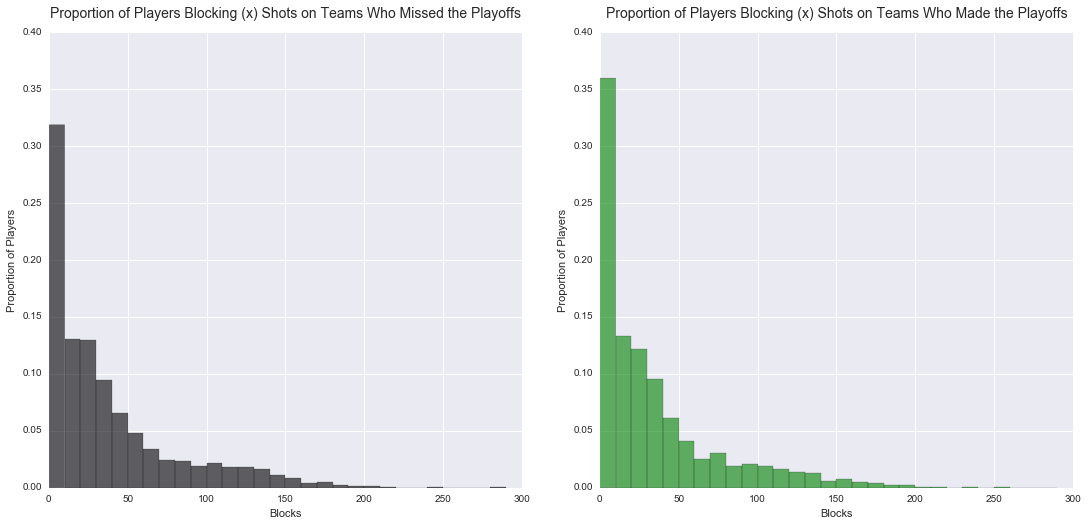

In [6]:
# Plot histogram of player blocks by teams who made the playoffs.
b = np.arange(0, 300, 10)
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 8))
pl.tight_layout(pad=5)

ax1.hist(playoffs['Blocks'], bins=b, alpha=0.6, facecolor='k',
         weights=(np.ones_like(playoffs['Blocks']) /
                  float(len(playoffs['Blocks']))),
         label="Player Block Proportion")
ax1.axis([0, 300, 0, 0.4])
ax1.set_xlabel('Blocks')
ax1.set_ylabel('Proportion of Players')
ax1.set_title('Proportion of Players Blocking (x) Shots on Teams ' +
              'Who Missed the Playoffs', y=1.02, fontsize=14)

ax2.hist(noplayoffs['Blocks'], bins=b, alpha=0.6, facecolor='g',
         weights=(np.ones_like(noplayoffs['Blocks']) /
                  float(len(noplayoffs['Blocks']))),
         label="Player Block Proportion")
ax2.axis([0, 300, 0, 0.4])
ax2.set_xlabel('Blocks')
ax2.set_ylabel('Proportion of Players')
ax2.set_title('Proportion of Players Blocking (x) Shots on Teams ' +
              'Who Made the Playoffs', y=1.02, fontsize=14)

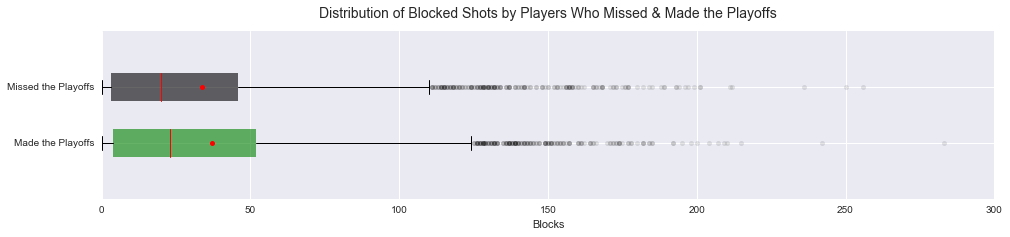

In [7]:
# Plot box plot of both distributions.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 3))
blockdata = [playoffs['Blocks'], noplayoffs['Blocks']]
colors = ['g', 'k']

flierprops = dict(marker='o', markerfacecolor='black',
                  markersize=5, linestyle='none', alpha=0.1)

meanpointprops = dict(marker='o', markersize=5,
                      markerfacecolor='r', linestyle='none')

box = ax1.boxplot(blockdata, vert=False, widths=0.5,
                  labels=['Made the Playoffs', 'Missed the Playoffs'],
                  patch_artist=True, showmeans=True, flierprops=flierprops,
                  meanprops=meanpointprops)

for patch, x in zip(box['boxes'], colors):
    patch.set(facecolor=x, alpha=0.6, linewidth=0)

pl.setp(box['whiskers'], color='k', linestyle='-')
ax1.axis([0, 300, 0, 3])
ax1.set_xlabel('Blocks')
ax1.set_title('Distribution of Blocked Shots by Players Who Missed & Made the Playoffs', y=1.05, fontsize=14)

In [8]:
print stats.ks_2samp(playoffs['Blocks'], noplayoffs['Blocks'])

Ks_2sampResult(statistic=0.049410497034784229, pvalue=0.0014921319669529932)


## Finding:
There is a significant difference between the distribution of blocked shots on playoff teams and non-playoff teams.
# Do blocked shots translate to wins?
$H_o$: Blocked shots do not have a relationship with wins.

$H_a$: Blocked shots have a relationship with wins.

In [9]:
# OLS of wins and blocks.
results = sm.ols('W ~ Blocks', data=data).fit()
print "y = ", results.params[1].round(5), "x +", results.params[0].round(2)
results.summary()

y =  0.00917 x + 30.38


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.468
Date:                Mon, 09 Jan 2017   Prob (F-statistic):             0.0118
Time:                        20:24:37   Log-Likelihood:                -606.53
No. Observations:                 180   AIC:                             1217.
Df Residuals:                     178   BIC:                             1223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     30.3819      4.208      7.219      0.000        22.077    38.687
Blocks         0.0092      0.004      2.543      0.012         0.002     0.016
==============================================================================
Omnibus:                        3.282   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                3.343
Skew:                          -0.313   Prob(JB):                        0.188
Kurtosis:                       2.769   Cond. No.                     9.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Plot scatter plot of team wins and blocks.
tls.set_credentials_file(username='jvani', api_key=os.getenv('PLOTLY_API'))
label = 'Team: ' + data['Team'] + '<br>Year: ' + data['Year']
OLS_line = data.Blocks * results.params[1] + results.params[0]

team_data = go.Scattergl(x=data.Blocks, y=data.W, mode='markers',
                         marker=dict(color='rgb(0, 0, 0)'), name='Teams',
                         text=label)

l_data = go.Scattergl(x=data.Blocks, y=OLS_line, mode='lines',
                      marker=dict(color='rgb(255, 0, 0)'),
                      name='OLS Regression')

layout = go.Layout(title='Wins vs. Blocked Shots For Every Team Since 2009',
                   plot_bgcolor='rgb(229, 229, 229)',
                   xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)',
                                  gridcolor='rgb(255,255,255)',
                                  title='Blocked Shots'),
                   yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)',
                                  gridcolor='rgb(255,255,255)',
                                  title='Wins'))

py_data = [team_data, l_data]
fig = go.Figure(data=py_data, layout=layout)

py.iplot(fig, filename='NHL_Team_Blocks')

## Finding:
Blocked shots have a positive relationship with wins.

In [ ]:
# Export data.
data.to_csv('TeamBlocks.csv')
playerdata.to_csv('PlayerBlocks.csv')